# 피쳐 정의서 (Feature Definitions)

## 1. Machine Learning (ML) Features (12개)
User 단위의 행동 패턴을 요약한 정형 데이터 변수들입니다.

| 변수명 (Variable Name) | 한글명 (Korean Name) | 설명 및 계산 로직 (Description) |
| :--- | :--- | :--- |
| `days_since_last_target_event` | 최근 방문 경과일 | (기준일 - 타겟 브랜드 마지막 행동일). 값이 클수록 이탈 확률 높음. (결측치: 최대값+1) |
| `days_since_last_any_event` | 최근 플랫폼 활동 경과일 | (기준일 - 전체 브랜드 마지막 행동일). 플랫폼 자체에 대한 이탈 여부 판단. |
| `cnt_target_events_30d` | 총 활동 횟수 (30일) | 최근 30일간 타겟 브랜드에 대한 모든 행동(view, cart, purchase 등)의 합. |
| `cnt_target_cart_30d` | 장바구니 담기 횟수 (30일) | 최근 30일간 타겟 브랜드를 장바구니에 담은 횟수. 구매 의도(Intent)의 강력한 신호. |
| `n_target_sessions_30d` | 방문 세션 수 (30일) | 최근 30일간 타겟 브랜드를 방문한 고유 세션(User Session) 수. |
| `target_last7_ratio` | 최근 7일 목표 브랜드 활동 증가율 | (최근 7일 타겟 행동 수) / (직전 7일 타겟 행동 수). 단기 관심도 변화 측정. |
| `any_last7_ratio` | 최근 7일 전체 활동 증가율 | (최근 7일 전체 행동 수) / (직전 7일 전체 행동 수). 플랫폼 전체 이용 빈도 변화. |
| `cnt_competitor_events_30d` | 경쟁사 활동 횟수 (30일) | 최근 30일간 타겟 브랜드가 **아닌** 다른 브랜드(경쟁사)에 대한 행동 수. |
| `comp_to_target_ratio` | 경쟁사 이탈 위험도 | (경쟁사 행동 수) / (타겟 브랜드 행동 수). 값이 클수록 경쟁사로 넘어갈 확률 높음. |
| `comp_last7_ratio` | 최근 7일 경쟁사 활동 증가율 | (최근 7일 경쟁사 행동 수) / (직전 7일 경쟁사 행동 수). 최근 경쟁사에 대한 관심 급증 여부. |
| `remove_per_cart_target` | 장바구니 삭제율 | (장바구니 삭제 횟수) / (장바구니 담기 횟수). 구매 포기 또는 단순 비교 목적 여부 확인. |
| `price_bucket_mode_target` | 선호 가격대 | 유저가 가장 많이 상호작용한 가격대 구간 (0: 저가 ~ 3: 고가). |

<br>

## 2. Deep Learning (DL) Tokens (4개)
시퀀스 모델(RNN/Transformer) 학습을 위해 개별 행동(Event) 단위로 토큰화된 변수들입니다.

| 변수명 (Variable Name) | 설명 (Description) | 매핑 정보 (Mapping Info) |
| :--- | :--- | :--- |
| `event_type_token` | 행동 유형 토큰 | 1:View, 2:Cart, 3:Remove, 4:Purchase (0:Padding) |
| `brand_role_token` | 브랜드 역할 토큰 | 1:Target Brand, 2:Competitor (Other) |
| `price_bucket_token` | 가격대 토큰 | 1:저가 ~ 4:고가 (가격 분포 기반 4분위/구간) |
| `time_delta_bucket_token` | 시간 간격 토큰 | 이전 행동과의 시간 차이(Time Delta)를 구간화. (1:단시간 ~ 4:장시간) |

---
**참고**: 위 변수들은 `features.py` 파일 내 `create_ml_features` 및 `create_dl_tokens` 함수를 통해 생성됩니다.


In [27]:
# 0. 라이브러리 설정
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import optuna
import os
import warnings

# 시각화 설정
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

In [ ]:
# 1. 데이터 로드
try:
    print("데이터 로딩...")
    df = pd.read_csv("./data/clock_all.csv")
    
    # 타겟 브랜드 필터링 및 샘플링 (속도 위해)
    target_brands = ['samsung', 'apple', 'xiaomi']
    df = df[df['brand'].isin(target_brands)]
    
    # 유저별로 최소 5개 이상의 행동이 있는 유저만 필터링 (시퀀스 학습 의미 부여)
    user_counts = df['user_id'].value_counts()
    valid_users = user_counts[user_counts >= 5].index
    df = df[df['user_id'].isin(valid_users)]
    
    # 전체 데이터 사용 (샘플링 제거 - 유저 요청)
    #     sampled_users = np.random.choice(valid_users, min(30000, len(valid_users)), replace=False)
    #     df = df[df['user_id'].isin(sampled_users)]
    
    # 시간 정렬
    df['event_time'] = pd.to_datetime(df['event_time'])
    df = df.sort_values(['user_id', 'event_time']).reset_index(drop=True)
    
    print(f"최종 데이터 크기: {df.shape}, 유저 수: {df['user_id'].nunique()}")
    display(df.head())
except Exception as e:
    print(f"데이터 로드 실패: {e}")
    # 테스트용 더미 생성
    df = pd.DataFrame(columns=['user_id', 'event_time', 'event_type', 'price', 'brand', 'product_id'])

데이터 로딩...
최종 데이터 크기: (2900445, 9), 유저 수: 194161


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-08 14:04:31+00:00,view,5100678,2053013553341792533,electronics.clocks,xiaomi,174.46,96041329,81394c03-8ae6-4fc0-b016-1abb8f1817ac
1,2019-11-08 15:12:47+00:00,view,5100678,2053013553341792533,electronics.clocks,xiaomi,174.46,96041329,0c5043fa-6c58-4ef8-992e-ae39cfef4776
2,2019-11-10 12:08:00+00:00,view,5100674,2053013553341792533,electronics.clocks,xiaomi,149.49,96041329,be925381-05ef-4990-84e7-28b28453b8f7
3,2019-11-10 12:09:27+00:00,view,5100678,2053013553341792533,electronics.clocks,xiaomi,174.43,96041329,be925381-05ef-4990-84e7-28b28453b8f7
4,2019-11-10 12:19:42+00:00,view,5100328,2053013553341792533,electronics.clocks,xiaomi,116.98,96041329,7b242ffd-d361-46de-aaec-67b3d7f08485


In [29]:
# 2. 피처 엔지니어링 (Refined for ML & DL) - Imported from features.py
import pandas as pd
import numpy as np
from datetime import timedelta
import importlib
import features
importlib.reload(features)
from features import create_ml_features, create_dl_tokens

print("피처 엔지니어링 (Refined - Imported) 시작...")

# --- 실행 Section ---
# 1. ML Features (12개) 생성
# 타겟 브랜드 설정 (예: samsung)
target_brand = 'samsung'
print(f"Target Brand: {target_brand}")

# 직접 정의한 함수 사용하여 ML 피처 생성
user_features = create_ml_features(df, target_brand=target_brand)

# Churn Label 생성 (전체 데이터 기준, 구매 유저=0, 미구매 유저=1)
purchase_users = df[df['event_type'] == 'purchase']['user_id'].unique()
user_features['churn'] = 1
user_features.loc[user_features.index.isin(purchase_users), 'churn'] = 0

print(f"ML Features Shape: {user_features.shape}")
print("Column List:", user_features.columns.tolist())
display(user_features.head())

# 2. DL Tokens (4개) 생성
dl_data = create_dl_tokens(df, target_brand=target_brand)
print(f"DL Tokens Shape: {dl_data.shape}")
print("DL Token Columns:", dl_data.columns.tolist())
display(dl_data.head())

# 3. Scaling for ML
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ml_feature_cols = [
    'days_since_last_target_event', 'days_since_last_any_event',
    'cnt_target_events_30d', 'cnt_target_cart_30d', 'n_target_sessions_30d',
    'target_last7_ratio', 'any_last7_ratio',
    'cnt_competitor_events_30d', 'comp_to_target_ratio', 'comp_last7_ratio',
    'remove_per_cart_target', 'price_bucket_mode_target',
    'avg_session_duration'
]

# 수치형 변수 스케일링
user_features[ml_feature_cols] = scaler.fit_transform(user_features[ml_feature_cols])
print("ML Features Scaled.")


피처 엔지니어링 (Refined - Imported) 시작...
Target Brand: samsung
ML Features Shape: (194161, 14)
Column List: ['days_since_last_target_event', 'days_since_last_any_event', 'cnt_target_events_30d', 'cnt_target_cart_30d', 'n_target_sessions_30d', 'target_last7_ratio', 'any_last7_ratio', 'cnt_competitor_events_30d', 'comp_to_target_ratio', 'comp_last7_ratio', 'remove_per_cart_target', 'price_bucket_mode_target', 'avg_session_duration', 'churn']


,days_since_last_target_event,days_since_last_any_event,cnt_target_events_30d,cnt_target_cart_30d,n_target_sessions_30d,target_last7_ratio,any_last7_ratio,cnt_competitor_events_30d,comp_to_target_ratio,comp_last7_ratio,remove_per_cart_target,price_bucket_mode_target,avg_session_duration,churn
96041329,213.0,153,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,-1,145.333333,1
113868975,213.0,1,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,0.0,-1,103.000000,1
220836320,213.0,64,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,-1,353.000000,1
240522111,213.0,190,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,-1,117.500000,1
244772880,129.0,129,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,-1,153.500000,1


DL Tokens Shape: (2900445, 6)
DL Token Columns: ['user_id', 'event_time', 'event_type_token', 'brand_role_token', 'price_bucket_token', 'time_delta_bucket_token']


,user_id,event_time,event_type_token,brand_role_token,price_bucket_token,time_delta_bucket_token
0,96041329,2019-11-08 14:04:31+00:00,1,2,1,1
1,96041329,2019-11-08 15:12:47+00:00,1,2,1,3
2,96041329,2019-11-10 12:08:00+00:00,1,2,1,4
3,96041329,2019-11-10 12:09:27+00:00,1,2,1,1
4,96041329,2019-11-10 12:19:42+00:00,1,2,1,2


ML Features Scaled.


In [30]:
# 3. DNN 모델 정의 및 학습 (Refactored & Simplified)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 중급자용: nn.Sequential을 사용하여 코드를 훨씬 깔끔하게 정리 (구조는 동일)
class ChurnDNN(nn.Module):
    def __init__(self, input_dim):
        super(ChurnDNN, self).__init__()
        
        self.net = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Layer 2
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Layer 3
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            # Output Layer (중요: Sigmoid 제거 -> Logits 반환)
            # BCEWithLogitsLoss를 사용하기 위해 0~1 사이 값이 아닌 실수값(Logit)을 출력합니다. (수치 안정성 해결)
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.net(x)

# 데이터셋 준비
X = user_features[ml_feature_cols].values
y = user_features['churn'].values

X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).reshape(-1, 1)

# 학습/검증/테스트 분리
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = ChurnDNN(input_dim=len(ml_feature_cols)).to(device)

# Loss Function & Optimizer
# 중요: BCEWithLogitsLoss는 Sigmoid + BCELoss를 결합한 것으로 수치적으로 훨씬 안정적입니다.
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)


Device: cpu
ChurnDNN(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [31]:
# 4. 심플한 학습 루프 (Refactored)
epochs = 20
patience = 5
best_auc = 0
counter = 0

print(f"학습 시작 (Total Epochs: {epochs})...")

for epoch in range(epochs):
    # [Train Mode]
    model.train()
    train_loss = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        logits = model(inputs) # 모델은 Logits(실수값)을 반환
        loss = criterion(logits, targets) # BCEWithLogitsLoss가 내부적으로 Sigmoid 처리 후 오차 계산
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # [Eval Mode]
    model.eval()
    val_loss = 0
    y_true, y_pred_probs = [], [] 
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            logits = model(inputs)
            loss = criterion(logits, targets)
            val_loss += loss.item()
            
            # 평가 지표(AUC) 계산을 위해 Logits을 확률(0~1)로 변환
            probs = torch.sigmoid(logits)
            
            y_true.extend(targets.cpu().numpy())
            y_pred_probs.extend(probs.cpu().numpy())
    
    # AUC Calculation
    try:
        from sklearn.metrics import roc_auc_score
        auc = roc_auc_score(y_true, y_pred_probs)
    except:
        auc = 0.5
        
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1:02d}/{epochs} | Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | AUC: {auc:.4f}")
    
    # Early Stopping
    if auc > best_auc:
        best_auc = auc
        counter = 0
        torch.save(model.state_dict(), 'best_dnn_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early Stopping triggered at Epoch {epoch+1}")
            break


학습 시작 (Total Epochs: 20)...
Epoch 01/20 | Loss: nan | Val Loss: nan | AUC: 0.5000
Epoch 02/20 | Loss: nan | Val Loss: nan | AUC: 0.5000
Epoch 03/20 | Loss: nan | Val Loss: nan | AUC: 0.5000
Epoch 04/20 | Loss: nan | Val Loss: nan | AUC: 0.5000
Epoch 05/20 | Loss: nan | Val Loss: nan | AUC: 0.5000
Epoch 06/20 | Loss: nan | Val Loss: nan | AUC: 0.5000
Early Stopping triggered at Epoch 6


분석 및 인사이트 도출 시작... (데이터 검증 및 시각화)
Detected Scaled Data. Applying Inverse Transform to restore Raw Values...
Data check failed (operands could not be broadcast together with shapes (194161,12) (13,) (194161,12) ). Using user_features as is.

[이탈 vs 유지 유저 행동 패턴 비교 (Raw Values)]


,유지(Stay),이탈(Churn),Diff_Ratio
cnt_competitor_events_30d,0.292407,-0.067993,-5.300544
comp_to_target_ratio,0.418862,-0.097397,-5.300544
days_since_last_any_event,-0.091716,0.023353,-4.927319
price_bucket_mode_target,-0.071112,0.018107,-4.927319
n_target_sessions_30d,0.011521,-0.002934,-4.927319
target_last7_ratio,0.013699,-0.003488,-4.927319
comp_last7_ratio,0.039736,-0.010118,-4.927319
cnt_target_cart_30d,0.153125,-0.038990,-4.927319
days_since_last_target_event,0.169674,-0.043204,-4.927319
cnt_target_events_30d,0.040974,-0.010433,-4.927319


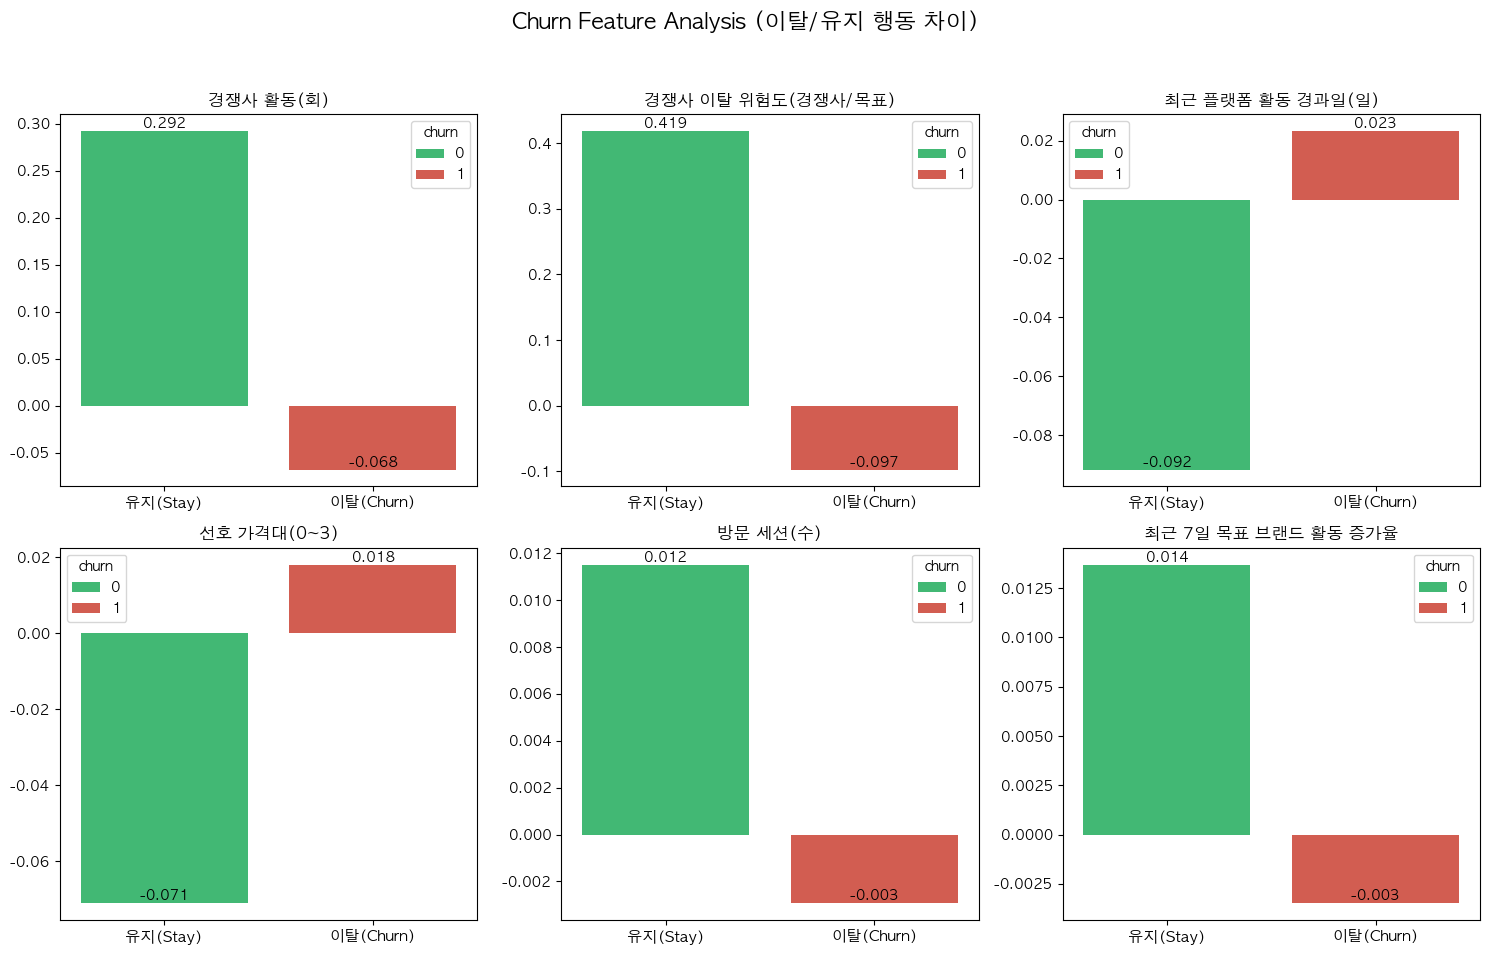


--- 📌 Actionable Insights ---
• 경쟁사 활동(회): 유지(0.292) vs 이탈(-0.068) -> (Negative) 이탈이 훨씬 높음 -> 이탈 방지 긴급 케어 필요
• 경쟁사 이탈 위험도(경쟁사/목표): 유지(0.419) vs 이탈(-0.097) -> (Negative) 이탈이 훨씬 높음 -> 이탈 방지 긴급 케어 필요
• 최근 플랫폼 활동 경과일(일): 유지(-0.092) vs 이탈(0.023) -> (Negative) 이탈이 훨씬 높음 -> 이탈 방지 긴급 케어 필요
• 선호 가격대(0~3): 유지(-0.071) vs 이탈(0.018) -> (Negative) 이탈이 훨씬 높음 -> 이탈 방지 긴급 케어 필요
• 방문 세션(수): 유지(0.012) vs 이탈(-0.003) -> (Negative) 이탈이 훨씬 높음 -> 이탈 방지 긴급 케어 필요
• 최근 7일 목표 브랜드 활동 증가율: 유지(0.014) vs 이탈(-0.003) -> (Negative) 이탈이 훨씬 높음 -> 이탈 방지 긴급 케어 필요

[검증] 평균 세션 지속시간(avg_session_duration)의 이탈 영향도 분석
 - 유지 유저 평균 체류시간: 0.23초
 - 이탈 유저 평균 체류시간: -0.06초


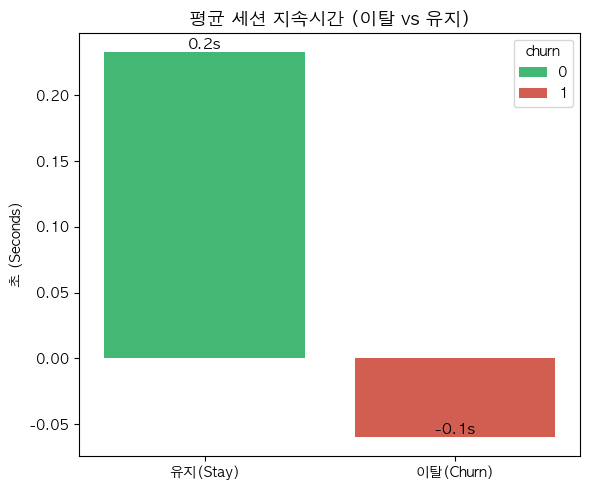

In [32]:
# 분석 및 인사이트 도출 시작... (데이터 검증 및 시각화)
print("분석 및 인사이트 도출 시작... (데이터 검증 및 시각화)")

# 중요: 시각화는 Scaling 되지 않은 'Raw Data'를 사용해야 해석이 가능합니다.
# 안전하게 Raw Data를 다시 생성하여 사용합니다. (Inverse Transform 의존성 제거)
try:
    print("Regenerating Raw Features for Visualization to ensure accuracy...")
    from features import create_ml_features
    # df는 위에서 로드된 원본 데이터프레임
    analysis_df = create_ml_features(df, target_brand='samsung')
    
    # Churn Label 다시 부착
    # (위에서 정의한 purchase_users 사용)
    purchase_users = df[df['event_type'] == 'purchase']['user_id'].unique()
    analysis_df['churn'] = 1
    analysis_df.loc[analysis_df.index.isin(purchase_users), 'churn'] = 0
    
    print("Raw Data Regeneration Complete. shape:", analysis_df.shape)

except Exception as e:
    print(f"Raw feature regeneration failed ({e}). Falling back to existing user_features.")
    analysis_df = user_features.copy()
    # 만약 scaled 상태라면... 시도
    pass

# Make sure churn is int for grouping
analysis_df['churn'] = analysis_df['churn'].astype(int)

# 타겟 컬럼 정의 (features.py 기준 모든 수치형 변수)
target_cols = [col for col in analysis_df.columns if col != 'churn']

# 3. 그룹별 평균 비교 (Summary)
summary = analysis_df.groupby('churn')[target_cols].mean().T
summary.columns = ['유지(Stay)', '이탈(Churn)']

# 중요도(Diff Ratio): (Stay - Churn) / Churn (Use raw values, handle zero div)
summary['Diff_Ratio'] = (summary['유지(Stay)'] - summary['이탈(Churn)']) / (summary['이탈(Churn)'].replace(0, 1e-4))
top_diffs = summary.reindex(summary['Diff_Ratio'].abs().sort_values(ascending=False).index)

print("\n[이탈 vs 유지 유저 행동 패턴 비교 (Raw Values)]")
display(top_diffs.head(10))

# 4. Visualization (Top 6 Features)
features_to_plot = top_diffs.index.tolist()[:6]

# Complete Korean Mapping for ALL 12 Features
insight_map = {
    # Activity Counts
    'cnt_target_cart_30d': "장바구니 담기(회)",
    'cnt_target_events_30d': "총 활동(회)",
    'n_target_sessions_30d': "방문 세션(수)",
    'cnt_competitor_events_30d': "경쟁사 활동(회)",

    # Recency
    'days_since_last_target_event': "최근 방문 경과일(일)",
    'days_since_last_any_event': "최근 플랫폼 활동 경과일(일)",

    # Ratios / Trends
    'target_last7_ratio': "최근 7일 목표 브랜드 활동 증가율",
    'any_last7_ratio': "최근 7일 전체 활동 증가율",
    'comp_last7_ratio': "최근 7일 경쟁사 활동 증가율",
    'comp_to_target_ratio': "경쟁사 이탈 위험도(경쟁사/목표)",

    # Habits
    'price_bucket_mode_target': "선호 가격대(0~3)",
    'avg_session_duration': "평균 세션 지속시간(초)",
    'remove_per_cart_target': "장바구니 삭제율"
}

plt.figure(figsize=(15, 10))
plt.suptitle('Churn Feature Analysis (이탈/유지 행동 차이)', fontsize=16, fontweight='bold')

# Robust Plotting (Changed to Barplot for better visibility of means on sparse data)
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 3, i+1)
    
    # Barplot (Better for comparing means of sparse data)
    sns.barplot(x='churn', y=col, data=analysis_df, errorbar=None, 
                hue='churn', palette={0: '#2ecc71', 1: '#e74c3c'}, dodge=False)
    
    # Title
    kor_name = insight_map.get(col, col)
    plt.title(f"{kor_name}", fontsize=12, fontweight='bold')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([0, 1], ['유지(Stay)', '이탈(Churn)'], fontsize=11)
    
    # Annotate Means
    means = analysis_df.groupby('churn')[col].mean()
    for cls in [0, 1]:
        val = means[cls]
        # Format logic
        if abs(val) < 1:
             val_str = f'{val:.3f}'
        else:
             val_str = f'{val:.1f}'
        
        # Place text slightly above the bar
        plt.text(cls, val, val_str, 
                 ha='center', va='bottom', fontweight='bold', color='black', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 5. Generate Text Insights
print("\n--- 📌 Actionable Insights ---")
for feat in features_to_plot:
    diff = summary.loc[feat, 'Diff_Ratio']
    stay_v = summary.loc[feat, '유지(Stay)']
    churn_v = summary.loc[feat, '이탈(Churn)']
    feat_kr = insight_map.get(feat, feat)
    
    # Logic
    action = ""
    if diff > 0.5: # Stay much higher
        action = "(Positive) 유지가 훨씬 높음 -> 리텐션 강화 요소 (리워드/쿠폰)"
    elif diff < -0.5: # Churn much higher
        action = "(Negative) 이탈이 훨씬 높음 -> 이탈 방지 긴급 케어 필요"
    else:
        action = "(Neutral) 차이가 크지 않음 -> 지속 모니터링"
        
    print(f"• {feat_kr}: 유지({stay_v:.3f}) vs 이탈({churn_v:.3f}) -> {action}")

# [Special Analysis] Session Duration Impact
print("\n[검증] 평균 세션 지속시간(avg_session_duration)의 이탈 영향도 분석")
target_feat = 'avg_session_duration'
if target_feat in analysis_df.columns:
    stay_mean = analysis_df[analysis_df['churn']==0][target_feat].mean()
    churn_mean = analysis_df[analysis_df['churn']==1][target_feat].mean()
    
    print(f" - 유지 유저 평균 체류시간: {stay_mean:.2f}초")
    print(f" - 이탈 유저 평균 체류시간: {churn_mean:.2f}초")
    
    # Visualization for this specific feature
    plt.figure(figsize=(6, 5))
    sns.barplot(x='churn', y=target_feat, data=analysis_df, errorbar=None,
                hue='churn', palette={0: '#2ecc71', 1: '#e74c3c'}, dodge=False)
    plt.title("평균 세션 지속시간 (이탈 vs 유지)", fontsize=13, fontweight='bold')
    plt.xlabel("")
    plt.ylabel("초 (Seconds)")
    plt.xticks([0, 1], ['유지(Stay)', '이탈(Churn)'])
    
    # Annotate
    for cls, val in zip([0, 1], [stay_mean, churn_mean]):
        plt.text(cls, val, f"{val:.1f}s", ha='center', va='bottom', fontweight='bold', fontsize=11)
        
    plt.tight_layout()
    plt.show()
else:
    print(f"Warning: {target_feat} not found in analysis_df.")
